In [109]:
import os
import ntpath
import functools
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib.pylab as plt
import FileDialog  # for creating binary
from Tkinter import Tk
import tkFileDialog
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph
import librosa
import djitw
from feature_extraction import extractFeature
from statistics import lpf
from sklearn.metrics import silhouette_score
import peakutils
from seasonal import fit_trend
from mus_seg_late_demo import extract_features
%matplotlib inline

In [132]:
def extract_features(file_path, file_ext, feature, cutoff=0.1, sr=1, order=1,
                     beat_sync=True, n_fft=8, hop_length=4, scale=0.0, round_to=0.0, normalize=0):
    # set parameters
    save_feat = True

    # extract features
    feats = {}
    feats[feature], beat_times = extractFeature(
        file_path, file_ext, feature, scale=0.0, round_to=0.0, normalize=0,
        transpose=False, save=save_feat, beat_sync=beat_sync)
    # Compute log-amplitude
    feats[feature] = librosa.logamplitude(
        feats[feature], ref_power=feats[feature].max())
    # L2 normalize the columns, i.e. each frame
    feats[feature] = librosa.util.normalize(feats[feature], norm=2., axis=0)
    # low pass filtered signal
    feats['LPF({})'.format(feature)] = lpf(feats[feature], cutoff, sr, order)
    
    # ADD 2D-FFT
    # extract power spectrum of feature, remove F0
    data = np.array([librosa.core.stft(f, n_fft, hop_length)[1:, :]
                     for f in feats[feature]])
    # transpose and reshape FFT data to have (frequencies, n_obs)
    data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    feats['FFT({})'.format(feature)] = np.abs(data) ** 2
    
    return feats, beat_times


In [133]:
def distance_fn(i, X, window, step_size):
    # return np.sqrt(np.sum(
    # X[:, i:i+window] - X[:, i+step_size:i+step_size+window]) ** 2))
    # (pearsonr(X[:, i:i+window].flatten(),
    #   X[:, i+step_size:i+step_size+window].flatten())[0]+1)*.5
    # features are already normalized, equals to cosine distance
    x = X[:, i:i+window].flatten()
    y = X[:, i+step_size:i+step_size+window].flatten()
    distance = 1 - np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))
    # distance = np.arccos(cos_sim) / np.pi  # angular distance
    return distance

In [134]:
def compute_dtw_distance(x, y, metric):
    distance_matrix = sp.spatial.distance.cdist(x, y, metric=metric)
    # Non-diagonal additive path penalty is the median of the sim matrix
    add_pen = np.median(distance_matrix)
    x_indices, y_indices, cost = djitw.dtw(
        distance_matrix, gully=.96, additive_penalty=add_pen, inplace=False)
    # Normalize score by path length
    cost /= float(len(x_indices))
    # Normalize score by mean distance matrix value within path chunk
    cost /= distance_matrix[
        x_indices.min():x_indices.max()+1,
        y_indices.min():y_indices.max()+1].mean()
    if np.isnan(cost):
        pdb.set_trace()
    # cost is unbounded
    return cost

In [135]:
def compute_segmentation(data, window, step_size, kernel_size, flip=False, detrend=True):
    # compute localized distances
    d1 = np.array(map(functools.partial(distance_fn,
                                        X=data,
                                        window=window,
                                        step_size=step_size),
                         xrange(0, data.shape[1]-(step_size+window*2))))

    d2 = np.array(map(functools.partial(distance_fn,
                                        X=data,
                                        window=window,
                                        step_size=step_size*2),
                         xrange(0, data.shape[1]-(step_size*2+window*2))))

    d3 = np.array(map(functools.partial(distance_fn,
                                        X=data,
                                        window=window,
                                        step_size=step_size*3),
                         xrange(0, data.shape[1]-(step_size*3+window*2))))

    d4 = np.array(map(functools.partial(distance_fn,
                                        X=data,
                                        window=window,
                                        step_size=step_size*4),
                         xrange(0, data.shape[1]-(step_size*4+window*2))))

    d1[:len(d2)] = (d1[:len(d2)] + d2)/2
    d1[:len(d3)] = (d1[:len(d3)] + d3)/2
    d1[:len(d4)] = (d1[:len(d4)] + d4)/2
    
    distances = d1
    if flip:
        distances *= -1

    if detrend:
        distances = distances - fit_trend(distances)
    # find peaks in distance
    peaks, filtered = find_peaks(distances, kernel_size)
    return peaks, distances, filtered

In [136]:
def find_peaks(data, kernel_size):
    # create kernel
    window = sp.signal.general_gaussian(kernel_size, p=1, sig=4)
    # zero padding not to change shape of data
    data = np.append(np.repeat(data[0], kernel_size/2), data)
    # convolve, scale, find peaks
    filtered = sp.signal.fftconvolve(data, window, mode='same')[kernel_size/2:]
    filtered *= np.average(data) / np.average(filtered)
    peaks = sp.signal.argrelmax(filtered, 0, kernel_size/2)[0]
    peaks = np.insert(peaks, 0, 0)
    """
    peaks = peakutils.indexes(data, thres=0.2, min_dist=4)
    peaks = np.insert(peaks, 0, 0)
    return peaks, None
    """
    return peaks, filtered

In [137]:
def compute_clusters_dtw(matrix, algorithm, segments, to_similarity):
    if to_similarity:
        matrix = np.exp(-matrix)
    if algorithm == 'spectral':
        K = int(np.linalg.eig(sim_mat)[0][0])
        labels = SpectralClustering(
            n_clusters=K, n_init=32, affinity='precomputed').fit_predict(
                matrix)
    elif algorithm == 'dbscan':
        labels = DBSCAN(eps=0.5, min_samples=2,
                        metric='precomputed').fit_predict(matrix)
    else:
        raise Exception("Algorithm {} not supported".format(algorithm))

    # choose centroids
    centroids = np.array([np.random.choice(segments[labels == i], 1)
                          for i in xrange(max(labels)+1)])
    indices = [0]
    for i in xrange(len(centroids)):
        indices.append(indices[-1]+centroids[i][0].shape[0])

    centroids_ravel = centroids[0][0]
    for i in xrange(1, len(centroids)):
        centroids_ravel = np.vstack((centroids_ravel, centroids[i][0]))

    return centroids_ravel, labels, indices

In [138]:
def compute_clusters(data, length, algorithm):
    data_wide = np.array([data[m:m+length, :]
                          for m in xrange(len(data)-length)])
    data_wide = data_wide.reshape(
        data_wide.shape[0],
        data_wide.shape[1]*data_wide.shape[2])

    # with Agglomerative Clustering
    K_MIN, K_MAX = 2, 12
    if algorithm == 'agglomerative':
        knn_graph = kneighbors_graph(data_wide, K_MAX, include_self=False)
        clustering = [AgglomerativeClustering(linkage='complete',
                                              connectivity=knn_graph,
                                              n_clusters=l).fit(data_wide)
                      for l in xrange(K_MIN, K_MAX+1)]
    elif algorithm == 'spectral':
        clustering = [SpectralClustering(n_clusters=l,
                                         n_init=16,
                                         affinity='rbf').fit(data_wide)
                      for l in xrange(K_MIN, K_MAX+1)]
    else:
        raise Exception("Algorithm {} not supported".format(algorithm))

    scores = [silhouette_score(data_wide,
                               clustering[x].labels_,
                               metric='euclidean')
              for x in xrange(len(clustering))]

    # get best clusters
    idx_best = findElbow(np.dstack((xrange(K_MIN, K_MAX+1), scores))[0])
    idx_best = min(idx_best+1, 12)
    clustering = clustering[idx_best]
    labels = clustering.labels_

    # compute mean centroids
    centroids = np.array([data_wide[labels == i].mean(axis=0)
                          for i in xrange(max(labels)+1)])

    if centroids.shape[1] == 3 * length:
        centroids = centroids.reshape(
            1, centroids.shape[0]*length, centroids.shape[1]/length)
    else:
        centroids = centroids.reshape(
            centroids.shape[0] * length,
            centroids.shape[1] / length)

    return centroids, labels

In [139]:
def get_segments(data, peaks):
    segments = [data[peaks[i]:peaks[i+1]] for i in xrange(len(peaks)-1)]
    segments.append(data[peaks[-1]:-1])
    return np.array(segments)

In [154]:
beat_sync = True
sr = 1
cutoff = 0.1
scale=0
round_to=0
normalize=0
# set parameters
if beat_sync:
    n_fft = 8
    hop_length = 1
    window = 4
    step_size = 2
    kernel_size = 8
else:
    n_fft = 32
    hop_length = 16
    window = 4
    step_size = 2
    kernel_size = 4

In [155]:
filepath = '/Users/rafaelvalle/Desktop/research/music_segmentation/data/Radiohead/01 Burn the Witch.mp3'
feature='cqt'

In [156]:
# extract features
file_path, file_ext = os.path.splitext(filepath)
feats, beat_times = extract_features(
    file_path, file_ext, feature, cutoff=cutoff, sr=sr, scale=scale, round_to=round_to, normalize=normalize,
    beat_sync=beat_sync, n_fft=n_fft, hop_length=hop_length)

# convert beat_times to nicely formatted strings
beat_times_str = np.array(
    ['{}:{}'.format(int(x/60), int(x % 60)) for x in beat_times])

In [157]:
# perform segmentation
print '\tSegmentation'
flip = True
peaks = {}
distances = {}
distances_filtered = {}
segments = {}
for k, v in feats.items():
    peaks[k], distances[k], distances_filtered[k] = compute_segmentation(
        v, window, step_size, kernel_size, flip=flip)
    # computes segments
    segments[k] = get_segments(v.T, peaks[k])

	Segmentation


In [158]:
# compute pair-wise distances using DTW
print '\tDTW'
dtw_distances = {}
for k, v in segments.items():
    dists = np.zeros((len(v), len(v)))
    for i in xrange(len(v)):
        for j in xrange(len(v)):
            if i == j:
                dists[i, j] = 0.0
            else:
                dists[i, j] = compute_dtw_distance(
                    v[i], v[j], 'cosine')
    dtw_distances[k] = dists

	DTW


In [159]:
# perform clustering using DTW distances
"""
print '\tClustering'
clustering = {}
for k, v in dtw_distances.items():
    if np.isnan(v).any():
        pdb.bset_trace()
    clustering[k] = compute_clusters_dtw(v, 'dbscan', segments[k], False)
"""    

"\nprint '\tClustering'\nclustering = {}\nfor k, v in dtw_distances.items():\n    if np.isnan(v).any():\n        pdb.bset_trace()\n    clustering[k] = compute_clusters_dtw(v, 'dbscan', segments[k], False)\n"

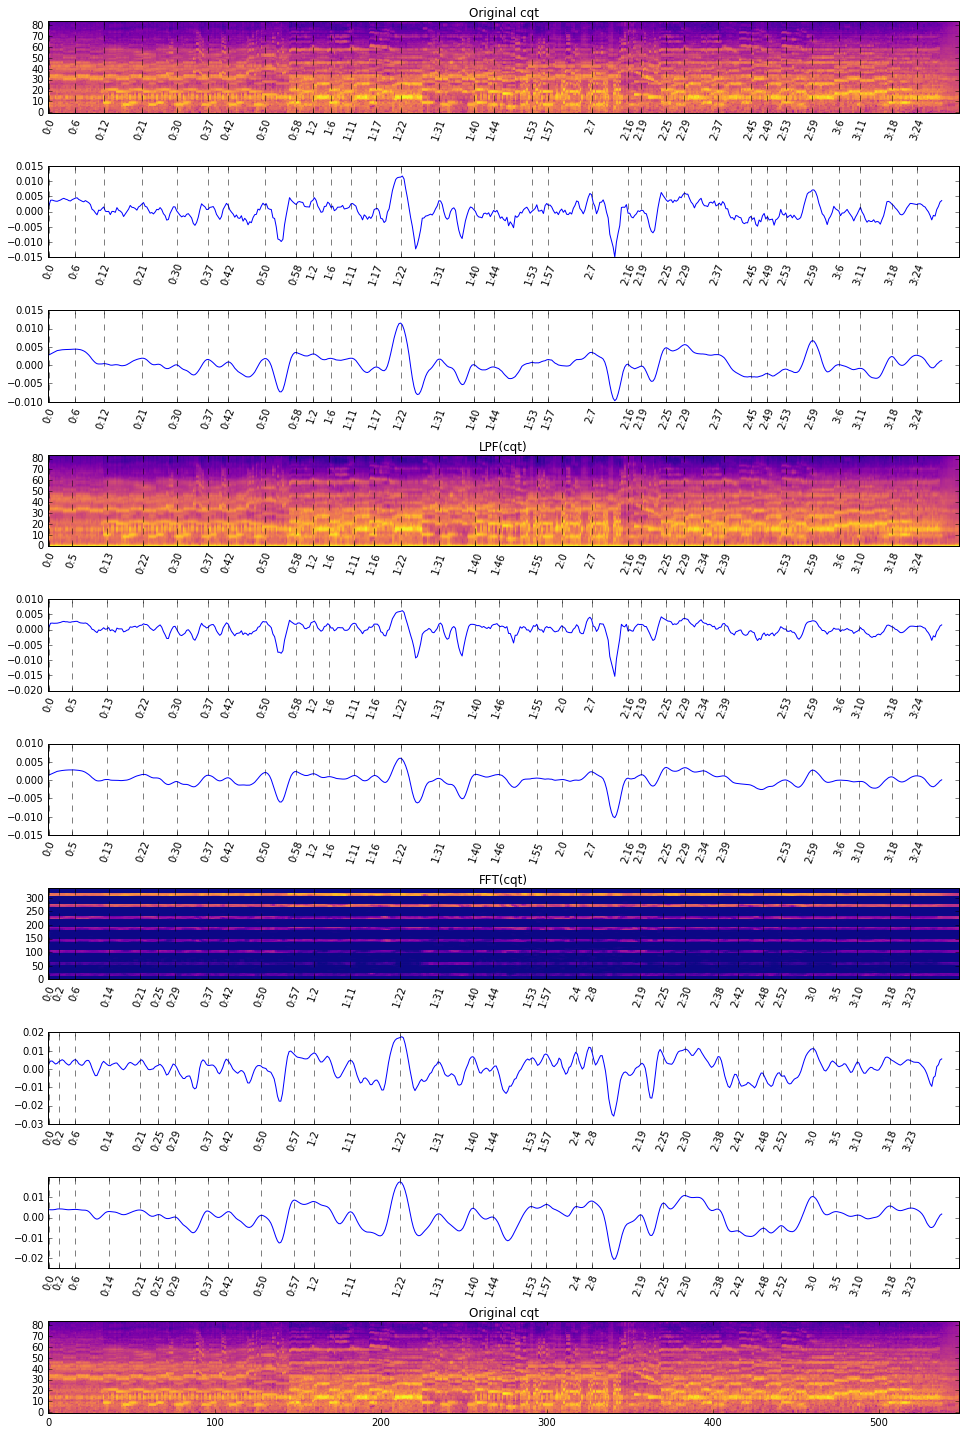

In [164]:
# clean axes and update data individually
plt.suptitle(ntpath.basename(file_path))
fig = plt.figure(figsize=(20, 20))
gs = mpl.gridspec.GridSpec(10, 2, width_ratios=[16, 8])

ax_plt = fig.add_subplot(gs[0, 0])
ax_plt.set_title('Original {}'.format(feature))
ax_plt.imshow(
    feats[feature],
    interpolation='nearest',
    origin='low',
    aspect='auto',
    cmap=plt.cm.plasma)
for p in peaks[feature]:
    ax_plt.axvline(p, color='k', linestyle='--', alpha=0.5)
ax_plt.set_xticks(peaks[feature])
ax_plt.set_xticklabels(beat_times_str[peaks[feature]], rotation=70)


"""
ax = fig.add_subplot(gs[0, 1])
ax.imshow(
    clustering[feature][0].T,
    interpolation='nearest',
    origin='low',
    aspect='auto',
    cmap=plt.cm.plasma)
ax.set_xticks(clustering[feature][2])
ax.set_xticklabels(xrange(1, max(clustering[feature][1])+2))
"""

ax = fig.add_subplot(gs[1, 0], sharex=ax_plt)
ax.plot(distances[feature])
for p in peaks[feature]:
    ax.axvline(p, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(peaks[feature])
ax.set_xticklabels(beat_times_str[peaks[feature]], rotation=70)

ax = fig.add_subplot(gs[2, 0], sharex=ax_plt)
ax.plot(distances_filtered[feature])
for p in peaks[feature]:
    ax.axvline(p, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(peaks[feature])
ax.set_xticklabels(beat_times_str[peaks[feature]], rotation=70)

ax_plt = fig.add_subplot(gs[3, 0])
ax_plt.set_title('LPF({})'.format(feature))
ax_plt.imshow(
    feats['LPF({})'.format(feature)],
    interpolation='nearest',
    origin='low',
    aspect='auto',
    cmap=plt.cm.plasma)
for p in peaks['LPF({})'.format(feature)]:
    ax_plt.axvline(p, color='k', linestyle='--', alpha=0.5)
ax_plt.set_xticks(peaks['LPF({})'.format(feature)])
ax_plt.set_xticklabels(beat_times_str[peaks['LPF({})'.format(feature)]], rotation=70)

ax = fig.add_subplot(gs[4, 0], sharex=ax_plt)
ax.plot(distances['LPF({})'.format(feature)])
for p in peaks['LPF({})'.format(feature)]:
    ax.axvline(p, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(peaks['LPF({})'.format(feature)])
ax.set_xticklabels(beat_times_str[peaks['LPF({})'.format(feature)]], rotation=70)

ax = fig.add_subplot(gs[5, 0], sharex=ax_plt)
ax.plot(distances_filtered['LPF({})'.format(feature)])
for p in peaks['LPF({})'.format(feature)]:
    ax.axvline(p, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(peaks['LPF({})'.format(feature)])
ax.set_xticklabels(beat_times_str[peaks['LPF({})'.format(feature)]], rotation=70)


ax_plt = fig.add_subplot(gs[6, 0])
ax_plt.set_title('FFT({})'.format(feature))
ax_plt.imshow(
    feats['FFT({})'.format(feature)],
    interpolation='nearest',
    origin='low',
    aspect='auto',
    cmap=plt.cm.plasma)
for p in peaks['FFT({})'.format(feature)]:
    ax_plt.axvline(p, color='k', linestyle='--', alpha=0.5)
ax_plt.set_xticks(peaks['FFT({})'.format(feature)])
ax_plt.set_xticklabels(
    beat_times_str[peaks['FFT({})'.format(feature)]*hop_length],
    rotation=70)

"""
ax = fig.add_subplot(gs[4, 1])
ax.imshow(
    clustering['FFT({})'.format(feature)][0].T,
    interpolation='nearest',
    origin='low',
    aspect='auto',
    cmap=plt.cm.plasma)
ax.set_xticks(clustering['FFT({})'.format(feature)][2])
ax.set_xticklabels(
    xrange(1, max(clustering['FFT({})'.format(feature)][1]+2)))
"""

ax = fig.add_subplot(gs[7, 0], sharex=ax_plt)
ax.plot(distances['FFT({})'.format(feature)])
for p in peaks['FFT({})'.format(feature)]:
    ax.axvline(p, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(peaks['FFT({})'.format(feature)])
ax.set_xticklabels(
    beat_times_str[peaks['FFT({})'.format(feature)]*hop_length],
    rotation=70)

ax = fig.add_subplot(gs[8, 0], sharex=ax_plt)
ax.plot(distances_filtered['FFT({})'.format(feature)])
for p in peaks['FFT({})'.format(feature)]:
    ax.axvline(p, color='k', linestyle='--', alpha=0.5)
ax.set_xticks(peaks['FFT({})'.format(feature)])
ax.set_xticklabels(
    beat_times_str[peaks['FFT({})'.format(feature)]*hop_length],
    rotation=70)

ax_plt = fig.add_subplot(gs[9, 0])
ax_plt.set_title('Original {}'.format(feature))
ax_plt.imshow(
    feats[feature],
    interpolation='nearest',
    origin='low',
    aspect='auto',
    cmap=plt.cm.plasma)

plt.tight_layout()
plt.draw()